In [30]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm 
import time

In [10]:
#######################################################
#               Define Transforms
#######################################################

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
####################################################
#       Create Train, Valid and Test sets
####################################################

train_data_path = '/opt/ml/input/data/train/images_classified' 
test_data_path = '/opt/ml/input/data/eval/images'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> '/opt/ml/input/data/train/images_classified/6/001201_male_Asian_26_incorrect_mask.jpg'
# eg. class -> 6
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = sum((train_image_paths),[])
random.shuffle(train_image_paths)

i = 2
print('train_image_path example: ', train_image_paths[i])
print('class example: ', classes[i])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


#3.
# create the test_image_paths
test_image_paths = []

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)


print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))




train_image_path example:  /opt/ml/input/data/train/images_classified/4/005495_female_Asian_48_mask5.jpg
class example:  5
Train size: 15120
Valid size: 3780
Test size: 12600


In [4]:
idx_to_class = {int(j):j for i, j in enumerate(classes)}
class_to_idx = {value: int(value) for key,value in idx_to_class.items()}
idx_to_class[4]


'4'

In [59]:
#######################################################
#               Define Dataset Class
#######################################################

class TrainMaskDataset(Dataset):
    def __init__(self,image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image = image)["image"]
        return image,label


class TestMaskDataset(Dataset):
    def __init__(self,image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image = image)["image"]
        return image

#######################################################
#                  Create Dataset
#######################################################

train_dataset = TrainMaskDataset(train_image_paths,train_transforms)
valid_dataset = TrainMaskDataset(valid_image_paths,test_transforms)


test_dataset = TestMaskDataset(test_image_paths,test_transforms)

In [6]:
print('The shape of tensor for 3rd image in train dataset: ',train_dataset[2][0].shape)
print('The label for 3rd image in train dataset: ',train_dataset[2][1])

The shape of tensor for 3rd image in train dataset:  torch.Size([3, 256, 256])
The label for 3rd image in train dataset:  4


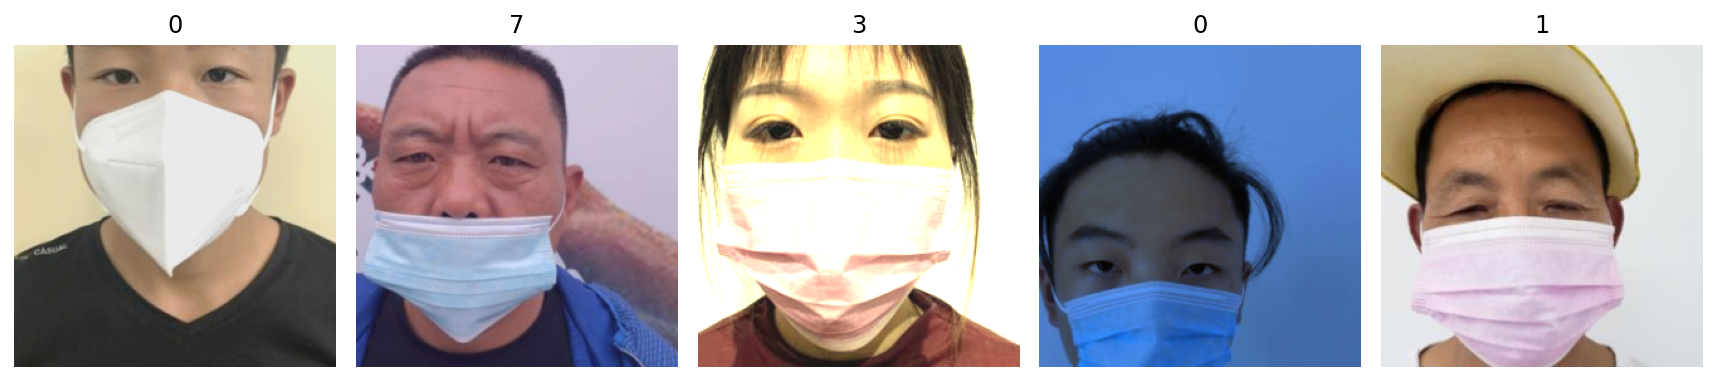

In [13]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=5, cols=5, random_img = False):
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [60]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=128, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)

In [15]:
# batch of image tensor
next(iter(train_loader))[0].shape

torch.Size([128, 3, 256, 256])

In [16]:
# batch of the corresponding labels
next(iter(train_loader))[1].shape

torch.Size([128])

In [21]:
#######################################################
#            Learning datasets to resnet18
#######################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=len(classes), bias=True)
torch.nn.init.xavier_uniform_(model.fc.weight)
stdv = 1. / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

print("네트워크 필요 입력 채널 개수", model.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", model.fc.weight.shape[0])
print("네트워크 구조",model)

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18
네트워크 구조 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [28]:
model.to(device)

LEARNING_RATE = 0.001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 


In [34]:
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(NUM_EPOCH):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad() # 전체 grad 값을 초기화.
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


#0 Loss: 0.5253 Acc: 82.0833% Time: 207.3447s



#1 Loss: 0.4491 Acc: 84.0939% Time: 395.7334s



#2 Loss: 0.3922 Acc: 86.2434% Time: 557.4659s



#3 Loss: 0.3718 Acc: 86.9841% Time: 717.8927s



#4 Loss: 0.3331 Acc: 88.4061% Time: 852.2093s


In [45]:
model.eval()
start_time = time.time()

all_labels = []
all_preds = []

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #all_preds.append(preds)
        
        for p in preds.cpu().numpy():
            all_preds.append(p)
        
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        
        #all_labels.append(labels.data)
        
        for l in labels.data.cpu().numpy():
            all_labels.append(l)
        
        # # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(valid_dataset)
    epoch_acc = running_corrects / len(valid_dataset) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.2068 Acc: 92.3545% Time: 34.7818s


In [48]:
from sklearn.metrics import f1_score
#from torchmetrics import F1Score

#f1 = F1Score(num_classes=18)
#f1(all_preds, all_labels)
f1_score(all_labels, all_preds, average='macro')

0.8139259243697965

In [52]:
import os
import pandas as pd

submission = pd.read_csv(os.path.join('/opt/ml/input/data/eval/', 'info.csv'))

In [61]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [62]:
submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,16
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,6
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,8
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,4
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,4
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,13
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,10
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,13


In [63]:
submission.to_csv(os.path.join('/opt/ml/input/data/eval/', 'submission.csv'), index=False)

In [64]:
os.getcwd()

'/opt/ml/git_test/code/kch'